# 12 - Doubly Robust Estimation

## Don't Put All your Eggs in One Basket

지금까지 선형회귀나 성향점수로 $E[Y|T=1] - E[Y|T=0] | X$를 추정하는 방법을 배웠습니다. 뭘 써야 할까요? 헷갈리면 둘 다 쓰세요! `Doubly Robust Estimation`은 선형회귀와 성향점수를 결합한 방법입니다.

`Doubly Robust Estimation`를 이해하기 위해 11장의 사고방식 데이터를 다시 살펴봅시다. 데이터는 성장 사고방식의 영향을 찾는 것을 목표로 미국 공립 고등학교에서 시행한 무작위 실험 결과입니다. 학생들에게 성장 사고방식을 심어주기 위한 세미나에 참석할 기회를 무작위로 주었습니다. 또한, 학생들의 대학 성적을 수집해 학업 성취도를 평가했습니다. 평가 결과는 `achievement_score`로 표준화된 값입니다. 학생의 사생활 보호를 위해 실제 데이터는 공개되지 않습니다. 대신 [Athey and Wager](https://arxiv.org/pdf/1902.07409.pdf)에서 발표한 통계적 특성이 같은 시뮬레이션 데이터를 사용해 보겠습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


무작위실험이지만 `confounder`가 존재합니다. `treatment`가 학생의 선택으로 결정되기 때문입니다. 세미나에 참여할 기회는 무작위로 제공하지만, 참여 자체는 무작위가 아닙니다. 9장에서 살펴본 `non-compliance`에 해당합니다. `confounder`에 대한 증거로 성공에 대한 기대(`success_expect`)와 세미나 참여(`intervention`)와의 상관관계를 확인해 봅시다. 성공에 대한 기대가 높은 학생은 성장 사고방식 세미나에 참여할 가능성이 높습니다.

In [3]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

선형 회귀나 로지스틱 회귀로 성향점수를 추정할 수 있습니다. 분석하기 전에 범주형 변수를 더미변수로 바꾸는 과정이 필요합니다.

In [4]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


그럼 `Doubly Robust Estimation`를 공부해봅시다.

## Doubly Robust Estimation

![img](./data/img/doubly-robust/double.png)

결과를 보기 전에 `Doubly Robust Estimation`가 왜 좋은지 알아봅시다.

$
\hat{ATE} = \frac{1}{N} \sum \left( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \right) - \frac{1}{N}\sum \left( \dfrac{(1-T_i)(Y_i - \hat{\mu_0}(X_i))}{1-\hat{P}(X_i)} + \hat{\mu_0}(X_i) \right)
$

$\hat{P}(x)$은 성향점수, $\hat{\mu_1}(x)$는 $E[Y|X, T=1]$, $\hat{\mu_0}(x)$는 $E[Y|X, T=0] 입니다. 첫 번째 항은 $E[Y_1]$를, 두 번째 항은 $E[Y_0]$를 추정합니다. 두 번째 항에 관한 내용은 첫 번째 항과 같으므로 첫 번째 항을 살펴봅시다.

공식이 무섭게 생겼으므로 (걱정하지 마세요. 사실은 매우 간단합니다.) 코드를 먼저 보여 드리겠습니다. 코드가 더 쉬울 때가 있더라고요. 실제로 어떻게 돌아가는지 봅시다.

In [5]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [6]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

0.3883429016212756

`Doubly Robust Estimator`는 세미나에 참석한 사람들이 0.388 표준편차만큼 대학 성적이 높을 것으로 기대합니다. 부트스트랩으로 신뢰 구간을 얻을 수 있습니다.

In [7]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [8]:
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

ATE 95% CI: (0.3536473084398494, 0.41978332830788145)


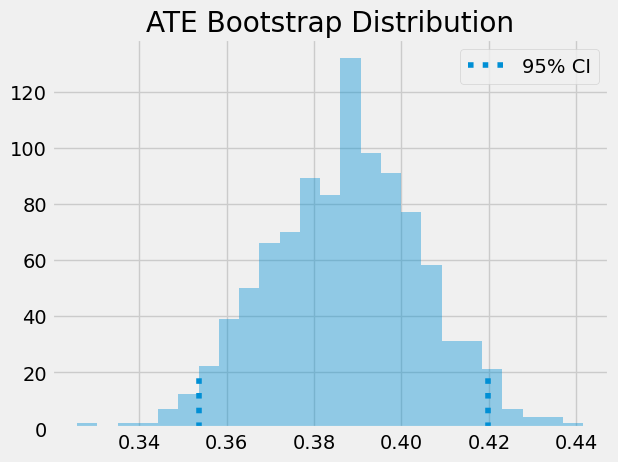

In [9]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

이제 왜 `Doubly Robust Estimator`가 훌륭한지 살펴봅시다. $\hat{P}(x)$, $\hat{\mu}(x)$ 중 하나만 올바르게 얻으면 되기 때문에 이중으로 견고(`Doubly Robust`)하다고 합니다. $E[Y_1]$를 추정하는 첫 번째 항을 자세히 살펴봅시다.

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$\hat{\mu_1}(x)$가 옳다고 가정해봅시다. 이 경우 성향점수가 잘못되어도 괜찮습니다. $\hat{\mu_1}(x)$가 정확하다면 $E[T_i(Y_i - \hat{\mu_1}(X_i))]=0$이기 때문입니다. $T_i$에 의한 곱셈은 `treated` 데이터만 선택하고 `treated`에 대한 $\hat{\mu_1}$ 잔차는 정의상 0입니다. 따라서 첫 번째 항은 $\hat{\mu_1}(X_i)$이 되고 가정에 따라 $E[Y_1]$와 같습니다. $\hat{\mu_1}(X_i)$가 정확하다면 성향점수는 `ATE`와 관련이 없습니다. $E[Y_0]$에 대해서도 똑같이 생각할 수 있습니다.

코드로 확인해봅시다. 추정기 `doubly_robust_wrong_ps`는 성향점수를 로지스틱 회귀 예측값 대신 0.1에서 0.9 사이의 무작위 값으로 대체합니다. 아주 작은 값으로 나누게 되면 수학적으로 불안정하므로 적당한 값을 택했습니다. 성향점수가 무작위이므로 성향점수 모델의 예측 수준은 매우 낮습니다. 하지만 `Doubly Robust Estimator`는 로지스틱 회귀를 적용했을 때와 매우 유사한 추정치를 도출합니다.

In [10]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_ps(df, X, T, Y):
    # wrong PS model
    np.random.seed(654)
    ps = np.random.uniform(0.1, 0.9, df.shape[0])
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [11]:
doubly_robust_wrong_ps(data_with_categ, X, T, Y)

0.38317552754886947

부트스트랩으로 신뢰 구간을 계산하면 로지스틱 회귀와 비교해 분산이 약간 더 크다는 사실을 알 수 있습니다.

In [12]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_ps)
wrong_ps = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                              for _ in range(bootstrap_sample))
wrong_ps = np.array(wrong_ps)

In [13]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

print(f"Wrong PS ATE 95% CI:", (np.percentile(wrong_ps, 2.5), np.percentile(wrong_ps, 97.5)))

Original ATE 95% CI: (0.3536473084398494, 0.41978332830788145)
Wrong PS ATE 95% CI: (0.3386612247232332, 0.43253110777289966)


성향점수를 망치는 것은 `ATE`를 약간만 바꿀 뿐입니다. 이는 성향점수 모델이 잘못되었지만 `outcome` 예측 모델이 올바른 경우에 해당합니다. 반대의 경우는 어떨까요? 첫 번째 항을 조금 바꿔 보겠습니다.

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \dfrac{T_i\hat{\mu_1}(X_i)}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i}{\hat{P}(X_i)} - 1\bigg) \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i - \hat{P}(X_i)}{\hat{P}(X_i)}\bigg) \hat{\mu_1}(X_i) \bigg)
$

이제 성향점수 $\hat{P}(X_i)$가 옳다고 가정해보겠습니다. $E[T_i - \hat{P}(X_i)]=0$이므로 $\hat{\mu_1}(X_i)$와의 관련성이 사라집니다. 이 경우 `Doubly Robust Estimator`는 `Propensity Score Weighting Estimator` $\frac{T_iY_i}{\hat{P}(X_i)}$와 같으며, 가정에 의해 참입니다. 따라서 $\hat{\mu_1}(X_i)$이 틀리더라도 성향점수만 옳다면 `Doubly Robust Estimator`는 여전히 맞습니다.

코드로 확인해봅시다. 아래 코드에서는 선형회귀 모델을 무작위 변수로 대체합니다. 이제 $\hat{\mu}(X_i)$는 **완벽하게 틀립니다.** 그럼에도 `Doubly Robust Estimator`는 유사한 결과를 도출합니다.

In [14]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_model(df, X, T, Y):
    np.random.seed(654)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    # wrong mu(x) model
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [15]:
doubly_robust_wrong_model(data_with_categ, X, T, Y)

0.39808033498544837

부트스트랩으로 신뢰 구간을 얻으면 분산이 커졌다는 사실을 알 수 있습니다.

In [16]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_model)
wrong_mux = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                               for _ in range(bootstrap_sample))
wrong_mux = np.array(wrong_mux)

In [17]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))
print(f"Wrong Mu ATE 95% CI:", (np.percentile(wrong_mux, 2.5), np.percentile(ates, 97.5)))

Original ATE 95% CI: (0.3536473084398494, 0.41978332830788145)
Wrong Mu ATE 95% CI: (0.3386881421243783, 0.41978332830788145)


나쁜 조건부 평균 모델을 사용하는 것도 `ATE`를 약간 바꿀 뿐입니다. `Doubly Robust Estimation`의 강력함은 편향을 제거하는 두 가지 방법에 따른 것입니다: `treatment`와 `outcome`을 모델링합니다. 이 중 하나의 모델만 맞아도 괜찮습니다.

실제로 둘 중 하나를 정확하게 모델링하는 것이 매우 어렵다는 사실에 주의해야 합니다. 성향점수나 결과모델이 100% 정확한 경우는 거의 없습니다. 서로 다른 방법으로 틀리므로 단일 모델이나 `Doubly Robust Estimation` 중 하나를 선택하기 어렵습니다[\[1\]](https://www.stat.cmu.edu/~ryantibs/journalclub/kang_2007.pdf)[\[2\]](https://arxiv.org/pdf/0804.2969.pdf)[\[3\]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2798744/). 하지만 저는 `Doubly Robust Estimation`을 좋아합니다. 여전히 둘 중 하나가 맞을 가능성이 있기 때문입니다.

## Key Ideas

이번 장에서는 선형회귀와 성향점수를 결합해 `Doubly Robust Estimation`를 만드는 방법을 공부했습니다. 두 모델 (`treatment` 예측 모델 또는 `outcome` 예측 모델) 중 하나만 맞으면 되기 때문에 `Doubly Robust Estimation` 이라는 이름이 붙었습니다. 성향점수 모델이 맞다면 결과 모델이 틀리더라도 인과관계를 파악할 수 있습니다. 반대의 경우도 마찬가지입니다.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

The data that we used was taken from the article [Estimating Treatment Effects with Causal Forests: An Application](https://arxiv.org/pdf/1902.07409.pdf), by Susan Athey and Stefan Wager. 

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).